In [1]:
import atmospy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
from datetime import datetime, timedelta
import pytz
import  numpy as np
import matplotlib.cm as cm

# disable warnings for demo purposes
warnings.filterwarnings("ignore")

atmospy.set_theme()

# this tutorial was completed using version:
atmospy.__version__

'0.1.2'

In [2]:
# Initialize an empty DataFrame
df_lcs = pd.DataFrame()

# Define the start and end months and years
start_month = 3
start_year = 2024
end_month = 4
end_year = 2024

# Function to generate month-year strings
def generate_month_year_strings(start_month, start_year, end_month, end_year):
    month_year_list = []
    year = start_year
    month = start_month
    while year < end_year or (year == end_year and month <= end_month):
        month_year_list.append(f"{year}_{str(month).zfill(2)}")
        month += 1
        if month > 12:
            month = 1
            year += 1
    return month_year_list

# Generate the list of month-year strings
month_year_strings = generate_month_year_strings(start_month, start_year, end_month, end_year)

# Loop through each month-year string and load the CSV files
for month_year_string in month_year_strings:
    year, month = month_year_string.split('_')
    filename_tail = f"@devnode_{year}-{month}.csv"
    directory = os.path.join("lcs_data", month_year_string)

    df_co = pd.read_csv(os.path.join(directory, f"raw_CO-B4{filename_tail}"), sep=',')
    df_pm_opcn3 = pd.read_csv(os.path.join(directory, f"raw_PM-OPCN3{filename_tail}"), sep=',')
    df_pm_sps30 = pd.read_csv(os.path.join(directory, f"raw_PM-SPS30{filename_tail}"), sep=',')
    df_trh = pd.read_csv(os.path.join(directory, f"raw_T_RH_P_BME280{filename_tail}"), sep=',')
    
    # Combining all datasets using the "Čas" column
    df_temp = pd.merge(df_co, df_trh, on="Čas")
    # df_temp = pd.merge(df_temp, df_no2, on="Čas")
    # df_temp = pd.merge(df_temp, df_ox, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_opcn3, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_sps30, on="Čas")
    
    # Calculating actual values for the WE (working electrode) and AE (auxiliary electrode) values
    df_temp["CO"] = df_temp["WE_CO"] - df_temp["AE_CO"]
    # df_temp["NH3"] = df_temp["WE_NH3"] - df_temp["AE_NH3"]
    # df_temp["NO2"] = df_temp["WE_NO2"] - df_temp["AE_NO2"]
    # df_temp["O3"] = df_temp["WE_O3"] - df_temp["AE_O3"]
      
    # Dropping the extra columns (including the pressure - that makes a negligible difference)
    df_temp = df_temp.drop(["WE_CO", "AE_CO", "PM_4"], axis=1)
    
    # Renaming the "Čas" column
    df_temp = df_temp.rename(columns={'Čas': 'Time'})
    
    # Converting the time to a datetime
    df_temp['Time'] = pd.to_datetime(df_temp['Time'])
    
    # 1h shift of the CSV data (CSV seems to be UTC+1, reference data UTC)
    df_temp['Time'] += pd.Timedelta(hours=1)
    
    # Set 'Time' column as the DataFrame index
    df_temp.set_index('Time', inplace=True)
    
    # Resample to 1-hour intervals and calculate the mean for each group
    df_temp_1h = df_temp.resample('1h').mean()
    
    # Assign the calculated hourly means back to the original DataFrame
    df_temp = df_temp_1h.reset_index()
    
    # Append the data to the main DataFrame
    df_lcs = pd.concat([df_lcs, df_temp], ignore_index=True)

# Renaming the "Time" column to "GMT"
df_lcs = df_lcs.rename(columns={'Time': 'GMT'})

# Set 'GMT' column as the DataFrame index
df_lcs.set_index('GMT', inplace=True)

# Print the data types of the final DataFrame
print(df_lcs.dtypes)

T          float64
RH         float64
p          float64
PM_1_x     float64
PM_2.5     float64
PM_10_x    float64
PM_1_y     float64
PM_2       float64
PM_10_y    float64
CO         float64
dtype: object


In [3]:
# The edited dataset has the "Celkem" values at the end of the data removed
#df_ref = pd.read_excel(month_year_string + "/MS_MarianskeHory_60min_" + month_year_string + "_edited.xlsx")
df_ref = pd.DataFrame()

df_ref = pd.read_csv('gmt_data/Nov-Apr_GMT_MarHory.csv', sep=';')

#df_ref = df_ref.rename(columns={
#        'Unnamed: 0': 'Time',
#        'Celaskon; 1663_MarHory; WSPE [m/s]': 'WSPE [m/s]',
#        'Celaskon; 1663_MarHory; WDIR [deg]': 'WDIR [deg]',
#        'Celaskon; 1663_MarHory; HUMI [%]': 'HUMI [%]',
#        'Celaskon; 1663_MarHory; PRES [hPa]': 'PRES [hPa]',
#        'Celaskon; 1663_MarHory; TEMP [°C]': 'TEMP [°C]',
#        'Celaskon; 1663_MarHory; PM10 [ug/m3]': 'PM10 [µg/m3]',
#        'Celaskon; 1663_MarHory; O3 [ug/m3]': 'O3 [µg/m3]',
#        'Celaskon; 1663_MarHory; SO2 [ug/m3]': 'SO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; NO [ug/m3]': 'NO [µg/m3]',
#        'Celaskon; 1663_MarHory; NO2 [ug/m3]': 'NO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; CO [ug/m3]': 'CO [µg/m3]'
#})

#Apply the function to the entire column
df_ref['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_ref['GMT'] = df_ref['GMT'].dt.tz_localize('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_ref = df_ref.drop(["TIME"], axis=1)

# Pokud potřebujete změnit pouze určité sloupce, můžete specifikovat sloupce takto:

df_ref[['WDIR [deg]', 
        'HUMI [%]', 
        'PRES [hPa]', 
        'TEMP [°C]', 
        'PM10 [ug/m3]', 
        'PM25 [ug/m3]', 
        'PM01 [ug/m3]', 
        'O3 [ug/m3]', 
        'SO2 [ug/m3]', 
        'NO [ug/m3]', 
        'NO2 [ug/m3]', 
        'CO [ug/m3]']] = df_ref[['WDIR [deg]', 
                                 'HUMI [%]', 
                                 'PRES [hPa]', 
                                 'TEMP [°C]', 
                                 'PM10 [ug/m3]', 
                                 'PM25 [ug/m3]', 
                                 'PM01 [ug/m3]', 
                                 'O3 [ug/m3]', 
                                 'SO2 [ug/m3]', 
                                 'NO [ug/m3]', 
                                 'NO2 [ug/m3]', 
                                 'CO [ug/m3]']].astype('float64')

#df_ref.head()
#print(df_ref.describe())
print(df_ref.dtypes)

GMT             datetime64[ns, UTC]
WSPE [m/s]                  float64
WDIR [deg]                  float64
HUMI [%]                    float64
PRES [hPa]                  float64
TEMP [°C]                   float64
PM10 [ug/m3]                float64
PM25 [ug/m3]                float64
PM01 [ug/m3]                float64
O3 [ug/m3]                  float64
SO2 [ug/m3]                 float64
NO [ug/m3]                  float64
NO2 [ug/m3]                 float64
CO [ug/m3]                  float64
dtype: object


In [4]:
# Merge the two DataFrames on the 'Time' column
df = pd.merge(df_lcs, df_ref, on='GMT')
# Sorting the values by the "Time" attribute
df.sort_values(by="GMT")
# Check the correlation between 'CO' and 'CO [µg/m3]'
#correlation = df_merged['CO'].diff().corr(df_merged['CO [ug/m3]'].diff())
#print(f'Correlation between CO and CO [µg/m3]: {correlation}')

,GMT,T,RH,p,PM_1_x,PM_2.5,PM_10_x,PM_1_y,PM_2,PM_10_y,...,PRES [hPa],TEMP [°C],PM10 [ug/m3],PM25 [ug/m3],PM01 [ug/m3],O3 [ug/m3],SO2 [ug/m3],NO [ug/m3],NO2 [ug/m3],CO [ug/m3]
0,2024-03-01 01:00:00+00:00,5.985100,100.0,985.000000,36.062400,172.843466,317.029633,64.729933,74.150400,81.253434,...,1015.0,5.5,27.0,NaN,NaN,5.0,5.5,30.2,34.2,831.1
1,2024-03-01 02:00:00+00:00,5.534528,100.0,984.566667,30.943167,162.509389,337.111277,56.423972,64.286667,70.043500,...,1014.0,5.2,19.0,NaN,NaN,5.0,5.5,26.3,33.7,771.1
2,2024-03-01 03:00:00+00:00,5.040167,100.0,983.961111,33.300917,182.369527,314.677279,58.556361,66.715556,72.689917,...,1013.0,4.8,22.0,NaN,NaN,5.0,5.5,26.6,28.3,828.8
3,2024-03-01 04:00:00+00:00,4.584528,100.0,983.177778,41.363195,218.032750,323.412500,59.799306,67.776917,73.435083,...,1013.0,4.6,31.0,NaN,NaN,5.0,5.5,33.0,30.5,840.3
4,2024-03-01 05:00:00+00:00,4.169389,100.0,983.080556,35.574917,166.733611,339.513806,58.769694,65.804639,70.362611,...,1013.0,4.0,26.0,NaN,NaN,5.0,5.5,38.5,30.9,846.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,2024-04-30 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1021.0,20.0,18.0,9.0,7.0,94.4,5.5,2.5,11.1,100.0
1459,2024-04-30 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1021.0,18.0,19.0,9.0,8.0,88.5,5.5,2.5,11.8,100.0
1460,2024-04-30 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1021.0,16.6,18.0,9.0,8.0,94.0,5.5,2.5,9.0,100.0
1461,2024-04-30 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1022.0,14.9,17.0,9.0,8.0,82.5,5.5,2.5,12.2,100.0


In [5]:
start_date = '2024-03-29'
end_date = '2024-04-03'

# Filter the DataFrame
sel_df = df[df['GMT'] >= start_date]
sel_df = sel_df[sel_df['GMT'] <= end_date]

# Sorting the values by the "GMT" attribute
df = sel_df.sort_values(by="GMT")

#df.head()
print(df[['TEMP [°C]','HUMI [%]','PRES [hPa]']].describe())

        TEMP [°C]    HUMI [%]   PRES [hPa]
count  121.000000  121.000000   121.000000
mean    15.275207   60.231405  1003.735537
std      5.166419   21.700522     3.570174
min      4.600000   32.000000   995.000000
25%     11.000000   40.000000  1002.000000
50%     15.700000   57.000000  1004.000000
75%     19.600000   76.000000  1007.000000
max     24.600000   99.000000  1009.000000


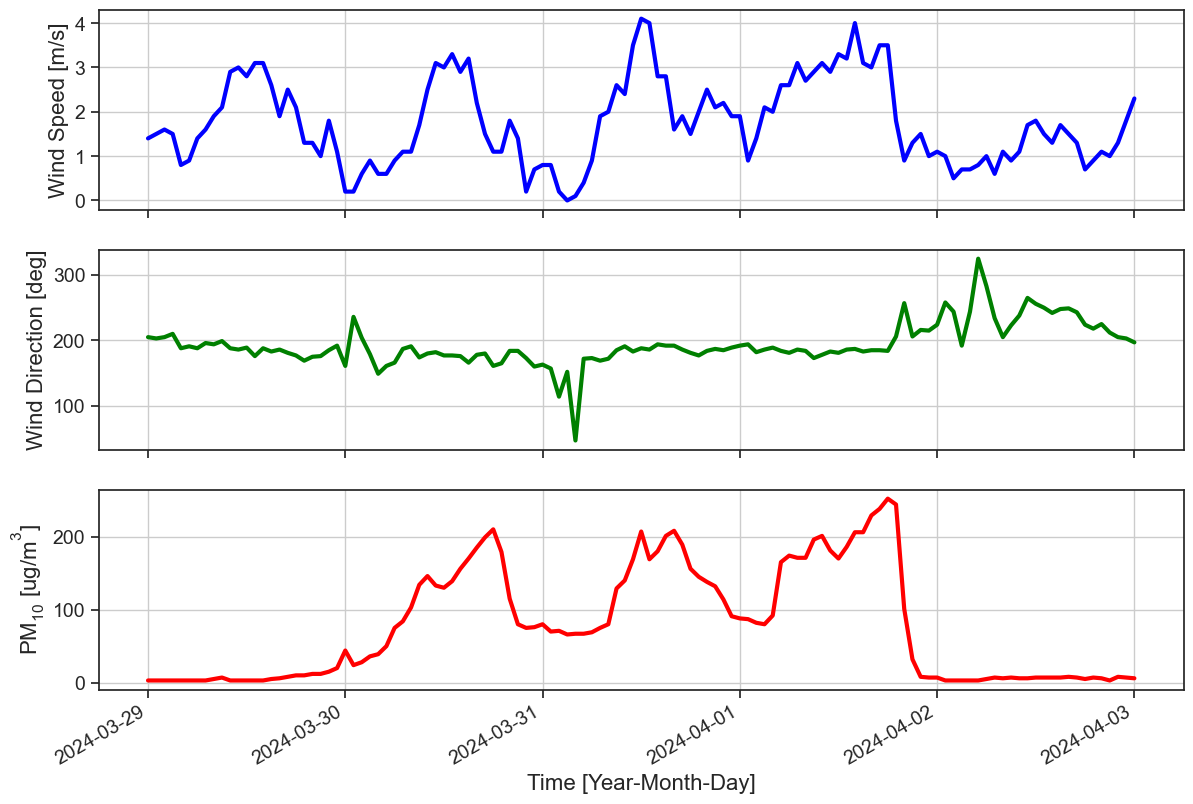

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot wind speed
ax1.plot(df['GMT'], df['WSPE [m/s]'], color='blue', label='Wind Speed', linewidth=3)
ax1.set_ylabel('Wind Speed [m/s]', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.grid(True)

# Plot wind direction
ax2.plot(df['GMT'], df['WDIR [deg]'], color='green', label='Wind Direction', linewidth=3)
ax2.set_ylabel('Wind Direction [deg]', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.grid(True)

# Plot PM10 concentration
ax3.plot(df['GMT'], df['PM10 [ug/m3]'], color='red', label='PM$_{10}$ Concentration', linewidth=3)
ax3.set_ylabel('PM$_{10}$ [ug/m$^3$]', fontsize=16)
ax3.set_xlabel('Time [Year-Month-Day]', fontsize=16)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.grid(True)

# Format x-axis to show timestamps
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

plt.show()

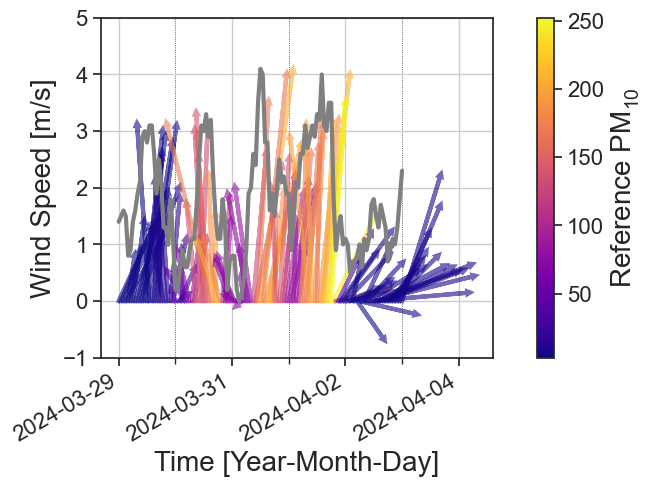

In [7]:
import matplotlib.dates as mdates

# Assuming df is your DataFrame
if 'GMT' in df.columns and not callable(df['GMT']):
    df['GMT'] = pd.to_datetime(df['GMT'])  # Convert to datetime if not already
else:
    raise ValueError("Column 'GMT' does not exist or is not accessible.")

# Resample data in 1-hour intervals for the arrow plot
df_resampled = df.resample('1H', on='GMT').mean().reset_index()

# Original data for the line plot
time = df['GMT']
wind_speed = df['WSPE [m/s]']

# Resampled data for the arrow plot
time_resampled = df_resampled['GMT']
wind_speed_resampled = df_resampled['WSPE [m/s]']
wind_direction_resampled = np.deg2rad(df_resampled['WDIR [deg]'])  # Convert degrees to radians
pm_values_resampled = df_resampled["PM10 [ug/m3]"]  # CO values for hue

# Adjust wind direction to match the plotting convention
wind_direction_resampled = np.pi*3/2 - wind_direction_resampled

fig, ax2 = plt.subplots(figsize=(14, 5))
ax2.set_aspect('equal', adjustable='box')

# Normalize CO values for colormap
norm = plt.Normalize(pm_values_resampled.min(), pm_values_resampled.max())
cmap = cm.plasma  # Use Plasma colormap

# Plot the original wind speed data
ax2.plot(time, wind_speed, color="gray", label='Wind Speed', linestyle="solid", linewidth=3)

arrow_length = 0.33  # Set a consistent arrow length
for t, ws, wd, pm in zip(time_resampled, wind_speed_resampled, wind_direction_resampled, pm_values_resampled):
    color = cmap(norm(pm))
    ax2.arrow(t, 0, ws * np.cos(wd), ws * np.sin(wd),  # Use consistent arrow length
              head_width=0.05, head_length=0.05, fc='none', ec=color, alpha=0.6, linewidth=3)

ax2.set_xlabel('Time [Year-Month-Day]', fontsize=20)  # Increase axis title size
ax2.set_ylabel('Wind Speed [m/s]', fontsize=20)  # Increase axis title size
ax2.grid(True)

# Increase tick label size
ax2.tick_params(axis='both', which='major', labelsize=16)

# Format x-axis to show timestamps
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Set major ticks to every second day
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date labels
ax2.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 24)))  # Set minor ticks to every 24 hours
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')  # Add minor grid lines

fig.autofmt_xdate()

# Add thicker colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)  # Increase colorbar tick label size
cbar.set_label('Reference PM$_{10}$', size=20)  # Increase colorbar label size

plt.ylim(-1, 5)
plt.show()


In [8]:
df["T"] = pd.to_numeric(df["T"], errors='coerce') + 273.15
df["CO"] = pd.to_numeric(df["CO"], errors='coerce') * 4394 + (-0.693)* pd.to_numeric(df["T"], errors='coerce')
df["CO [ug/m3]"] = pd.to_numeric(df["CO [ug/m3]"], errors='coerce')

#df_filter = df[df["CO [ug/m3]"] > 200]
#df_subfilter = df_filter[df_filter["CO [ug/m3]"] < 400]

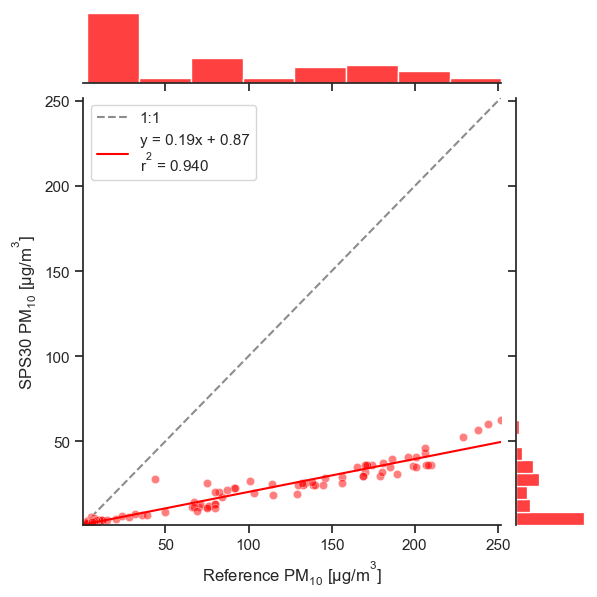

In [9]:
df["PM_10_y"] = pd.to_numeric(df["PM_10_y"], errors='coerce')

pm = atmospy.regplot(
    data=df,
    x="PM10 [ug/m3]", 
    y="PM_10_y",   
    color="red",
    marker='o',
    alpha=0.5
#    fit_reg=False
)
pm.set_axis_labels(xlabel="Reference $PM_{10}$ [$µg/m^{3}$]", ylabel="SPS30 $PM_{10}$ [$µg/m^{3}$]")

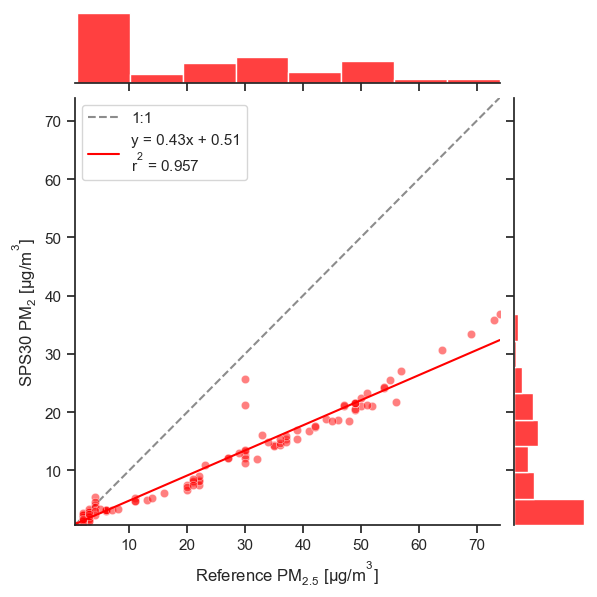

In [10]:
df["PM_2"] = pd.to_numeric(df["PM_2"], errors='coerce')

pm = atmospy.regplot(
    data=df,
    x="PM25 [ug/m3]", 
    y="PM_2",   
    color="red",
    marker='o',
    alpha=0.5
#    fit_reg=False
)
pm.set_axis_labels(xlabel="Reference $PM_{2.5}$ [$µg/m^{3}$]", ylabel="SPS30 $PM_{2}$ [$µg/m^{3}$]")

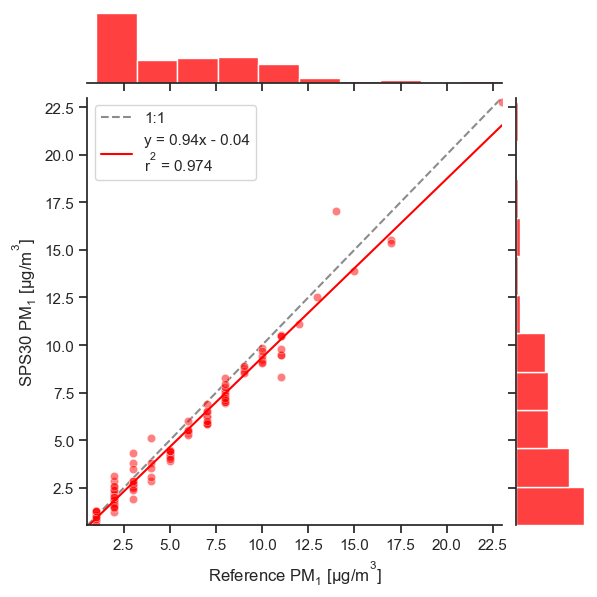

In [11]:
df["PM_1_y"] = pd.to_numeric(df["PM_1_y"], errors='coerce')

pm = atmospy.regplot(
    data=df,
    x="PM01 [ug/m3]", 
    y="PM_1_y",   
    color="red",
    marker='o',
    alpha=0.5
#    fit_reg=False
)
pm.set_axis_labels(xlabel="Reference $PM_{1}$ [$µg/m^{3}$]", ylabel="SPS30 $PM_{1}$ [$µg/m^{3}$]")

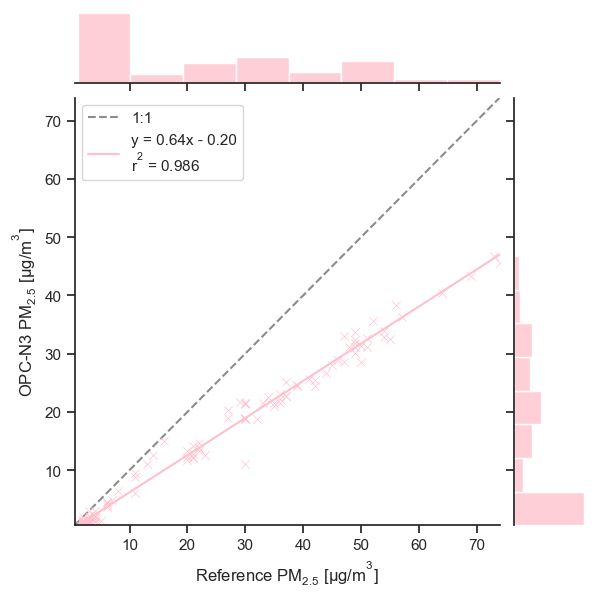

In [12]:
df["PM_2.5"] = pd.to_numeric(df["PM_2.5"], errors='coerce')

pm = atmospy.regplot(
    data=df,
    x="PM25 [ug/m3]", 
    y="PM_2.5",   
    color="pink",
    marker='x',
#    fit_reg=False
)
pm.set_axis_labels(xlabel="Reference $PM_{2.5}$ [$µg/m^{3}$]", ylabel="OPC-N3 $PM_{2.5}$ [$µg/m^{3}$]")